In [1]:
from nas_201_api import NASBench201API as API
api = API('NAS-Bench-201-v1_1-096897.pth', verbose=False)

In [69]:
import numpy as np
import random

# datasets = ['cifar10', 'cifar100', 'ImageNet16-120']
datasets = ['cifar100']

CONV3X3 = 'nor_conv_3x3'
CONV1X1 = 'nor_conv_1x1'
AVGPOOL3X3 = 'avg_pool_3x3'
SKIP = 'skip_connect'
ZEROIZE = 'none'

NUM_VERTICES = 4
ALLOWED_OPS = [CONV3X3, CONV1X1, AVGPOOL3X3, SKIP, ZEROIZE]   # Binary adjacency matrix
np.random.seed(1)

In [70]:
import numpy as np 

def convert_201(solution):
    transformed_solution = '|'
    for j in range(1, NUM_VERTICES):
        for i in range(NUM_VERTICES):
            if(solution[i][j] != ''):
                transformed_solution += solution[i][j] + '~' + str(i) + '|'
        if(j<NUM_VERTICES-1):
            transformed_solution += '+|'
    return transformed_solution


def fitness(solution):
    val = 0
    spec = convert_201(solution)
    index = api.query_index_by_arch(spec)
    for dataset in datasets:
        results = api.query_by_index(index, dataset)
        for seed, result in results.items():
            val += result.get_eval('ori-test')['accuracy']
    val /= len(datasets)
    return val            

In [71]:
def mutation(solution, mutation_rate=1.0):
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    # print(ALLOWED_OPS)
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if np.random.random() < edge_mutation_prob:
          # print('Before:', solution[src, dst])
          solution[src, dst] = np.random.choice(ALLOWED_OPS)
          # print('After:', solution[src, dst])
    # print(solution)
    return solution

def crossover(parent1, parent2):
    child1 = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES, NUM_VERTICES))
    child2 = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES, NUM_VERTICES))
    cross_point = np.random.randint(NUM_VERTICES-2)+1
  
    for i in range(NUM_VERTICES):
      if i<cross_point:
        child1[:,i] = parent1[:,i]
        child2[:,i] = parent2[:,i]
      else:
        child1[:,i] = parent2[:,i]
        child2[:,i] = parent1[:,i]

    return child1, child2


def selection(population, objective):
    # function to perform tournament selection
    K = 5
    num_pop = len(population)
    perm = np.random.permutation(num_pop)
    pop_comb = perm[0:K]
    tournament_fit = np.zeros(K)

    # creating tournament population
    for i in range(K):
        tournament_fit[i] = objective[pop_comb[i]]

    # declaring winners
    idx = np.argsort(tournament_fit)
    parent_id1 = idx[0] 
    parent_id2 = idx[1]
    return parent_id1, parent_id2


def initialization(pop_size):
  # function for initialization
    population = []
    for pop_no in range(pop_size):
      matrix = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES, NUM_VERTICES))
      matrix = np.triu(matrix,1)
      population.append(matrix)

    return population

In [72]:
def GA(pop_size=60, num_gen=500, max_cross=10, cross_mut_prob=0.5):
  # main driver function for GA
  population = initialization(pop_size)
  obj_values = np.zeros(pop_size)
  avg_values = np.zeros(num_gen)
  best_values = np.zeros(num_gen)
  for pop_no in range(pop_size):
    # calculate fitness for all the chromosomes
    # print(population[pop_no])
    # print(convert_201(population[pop_no]))
    obj_values[pop_no] = fitness(population[pop_no])
    # print(obj_values[pop_no])

  for gen_no in range(num_gen):
    avg_values[gen_no] = np.mean(obj_values)
    best_values[gen_no] = np.max(obj_values)
    # print(avg_values[gen_no])
    for i in range(max_cross):
      if(np.random.rand()<cross_mut_prob):
        # parent selection
        parent_id1, parent_id2 = selection(population, obj_values)

        # crossover
        # print('Before:', population[parent_id1], population[parent_id2])
        child_1, child_2 = crossover(population[parent_id1], population[parent_id2])
        # print('After:', child_1, child_2)

        # mutation
        child_1 = mutation(child_1)
        child_2 = mutation(child_2)

        # child fitness computation
        obj_1 = fitness(child_1)
        obj_2 = fitness(child_2)
        
        # child replaces the worst solution if applicable
        if(obj_1 > min(obj_values)):
            idx = np.argmin(obj_values)
            population[idx] = child_1
            obj_values[idx] = obj_1
            
        if(obj_2 > min(obj_values)):
            idx = np.argmin(obj_values)
            population[idx] = child_2
            obj_values[idx] = obj_2

  return avg_values, best_values

In [73]:
pop_size=100
num_gen=500
cross_mut_prob = 0.5
num_runs = 30
max_cross = 10

avg_val_plot = np.zeros((num_runs, num_gen))
best_val_plot = np.zeros((num_runs, num_gen))

for i in range(num_runs):
  avg_val_plot[i,:], best_val_plot[i,:] = GA(pop_size=pop_size, num_gen=num_gen, max_cross=max_cross, cross_mut_prob=cross_mut_prob)

Text(0, 0.5, 'Average Fitness Score')

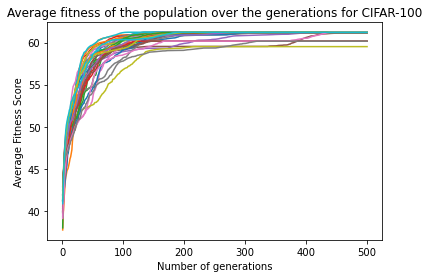

In [76]:
from matplotlib import pyplot as plt 

X = list(range(1, num_gen+1))
Y = avg_val_plot
# print(Y[1])
for i in range(num_runs):
  plt.plot(X, Y[i,:])

plt.title('Average fitness of the population over the generations for CIFAR-100')
plt.xlabel('Number of generations')
plt.ylabel('Average Fitness Score')

In [23]:
def random_spec():
  """Returns a random valid spec."""
  matrix = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES, NUM_VERTICES))
  matrix = np.triu(matrix, 1)
  return matrix


def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

def run_random_search(num_gen=100):
  """Run a single roll-out of random search to a fixed time budget."""
  best_acc = [0.0]
  for i in range(num_gen):
    spec = random_spec()
    cur_acc = fitness(spec) 
    if cur_acc > best_acc[-1]:
      best_acc.append(cur_acc)
    else:
      best_acc.append(best_acc[-1])

  return best_acc[1:]

def run_evolution_search(population_size=50,
                         num_gen = 100,
                         tournament_size=10,
                         mutation_rate=1.0):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  best_acc = [0.0]
  population = []   # (validation, spec) tuples
  avg_values = []
  best_values = []
  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  for _ in range(population_size):
    spec = random_spec()
    cur_acc = fitness(spec)
    population.append((cur_acc, spec))

    if cur_acc > best_acc[-1]:
      best_acc.append(cur_acc)
    else:
      best_acc.append(best_acc[-1])

  # After the population is seeded, proceed with evolving the population.
  for i in range(num_gen):
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutation(best_spec, mutation_rate)

    cur_acc = fitness(new_spec)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((cur_acc, new_spec))
    population.pop(0)

    if cur_acc > best_acc[-1]:
      best_acc.append(cur_acc)
    else:
      best_acc.append(best_acc[-1])

    avg_values.append(np.mean(best_acc))
    best_values.append(np.max(best_acc))

  return avg_values, best_values

In [26]:
num_runs = 30
num_gen = 500
best_values_evol_search = np.zeros(num_gen)
best_values_GA = np.zeros(num_gen)
best_values_RS = np.zeros(num_gen)

for runs in range(num_runs):
  _, best_values_evol_search_run  = run_evolution_search(num_gen=num_gen)
  _, best_values_GA_run = GA(num_gen=num_gen)
  best_values_RS_run = run_random_search(num_gen=num_gen)

  best_values_evol_search += best_values_evol_search_run
  best_values_GA += best_values_GA_run
  best_values_RS += best_values_RS_run

best_values_evol_search /= num_runs
best_values_GA /= num_runs
best_values_RS /= num_runs

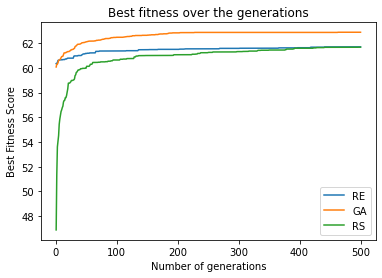

In [27]:
X = list(range(1, num_gen+1))
Y1 = best_values_evol_search
Y2 = best_values_GA
Y3 = best_values_RS
# print(Y[1])
plt.plot(X, Y1)
plt.plot(X, Y2)
plt.plot(X, Y3)

plt.title('Best fitness over the generations')
plt.xlabel('Number of generations')
plt.ylabel('Best Fitness Score')
plt.legend(['RE', 'GA', 'RS'])